# Reuters-21578 Text Classification

## Unsupervised Learning Capstone, Thinkful Data Science Bootcamp

Article category classification using the Reuters-21578 text categorization test collection; a resource for research in information retrieval, machine learning, and other corpus-based research.

Concepts & methods used in this project include:

- Unsupervised & supervised machine learning algorithms
- Unsupervised feature generation
- Text cleaning, preparation, tokenization and vectorization
- Dimensionality reduction techniques

In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re

import time
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

## Importing and preparing data

The corpus used for this project is the Reuters-21578 dataset, which is pre-loaded into nltk with category labels applied to each article, with some articles having more than one label. This notebook entails processing the data, splitting it into a couple different classification tasks, and using some unsupervised feature generation and clustering techniques to see how well they can classify the articles they're given. Then the same data is given to some supervised classification models to see how they perform with it.

Dataset information: 
The documents in the Reuters-21578 collection appeared on the Reuters newswire in 1987. The documents were assembled and indexed with categories by personnel from Reuters Ltd. (Sam Dobbins, Mike Topliss, Steve Weinstein) and Carnegie Group, Inc. (Peggy Andersen, Monica Cellio, Phil Hayes, Laura Knecht, Irene Nirenburg) in 1987

In [46]:
from nltk.corpus import reuters, stopwords

#each file is pre-labeled for train (~73%) and test (remaining 27%)
train_files = list(filter(lambda x: x.startswith('training'), reuters.fileids()))
test_files = list(filter(lambda x: x.startswith('test'), reuters.fileids()))

print(train_files[:3])
print(test_files[:3])
print("Total documents: ", len(reuters.fileids()))
print("Number of training documents: ", len(train_files))
print("Number of test documents: ", len(test_files))

['training/1', 'training/10', 'training/100']
['test/14826', 'test/14828', 'test/14829']
Total documents:  10788
Number of training documents:  7769
Number of test documents:  3019


In [112]:
print("Number of document categories in dataset: ",len(reuters.categories()))

Number of document categories in dataset:  90


In [365]:
#see what this data looks like
# Using raw() to store all the document text in the training and test files
train_raw = reuters.raw(train_files)
test_raw = reuters.raw(test_files)

# Taking a look at the first 500 characters in the training document text:
print(train_raw[0:500])


BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at th


In [60]:
#text cleaning function
def text_cleaner(text):
    text = re.sub(r'--',' ', text) #double hyphens cause problems
    text = re.sub('[^A-Za-z0-9]+', ' ', text) #matches characters that are not letters or numbers
    text = re.sub(r'\d+','', text) #this handles digits
    
    #comparison operators format weird
    text = re.sub(r'&lt;', ' ', text)
    text = re.sub(r'&gt;', ' ', text)
    text = re.sub(r'&le;', ' ', text)
    text = re.sub(r'&ge;', ' ', text)
    
    #lowercase and join
    text = text.lower()
    text = ' '.join(text.split())
    return text

There are 90 different categories that articles in the dataset can be labeled with, and many articles are labeled with multiple categories. 

In [113]:
# Taking a look at the documents and the respective number of categories they are labeled with
category_count = []
for file in reuters.fileids():
    category_count.append(len(reuters.categories(file)))
print("[Number of categories a document is labeled with, count]")
[[x, category_count.count(x)] for x in set(category_count)]

[Number of categories a document is labeled with, count]


[[1, 9160],
 [2, 1173],
 [3, 255],
 [4, 91],
 [5, 52],
 [6, 27],
 [7, 9],
 [8, 7],
 [9, 5],
 [10, 3],
 [11, 2],
 [12, 1],
 [14, 2],
 [15, 1]]

For the sake of simplicity and because ~85% of the documents are classified under one category, we will be looking at documents with only 1 category label

In [79]:
# Populating the train df
train_df = pd.DataFrame()
for file in train_files:
    # Filtering out articles with more than 1 category:
    if len(reuters.categories(file)) == 1:
        train_df = train_df.append({'category': ''.join(reuters.categories(file)),
                                    'fileid':file,
                                    'text':text_cleaner(reuters.raw(file))},
                                    ignore_index=True)
                                   
#inspect results        
print('\n{} train files; data shape is {}'.format(
    len(train_files), train_df.shape))
print('articles eliminated: {}\n'.format(len(train_files) - len(train_df)))
           
            


7769 train files; data shape is (6577, 3)
articles eliminated: 1192



 Taking a look at the training dataframe:

In [80]:
train_df.head()

,category,fileid,text
0,cocoa,training/1,bahia cocoa review showers continued throughou...
1,acq,training/10,computer terminal systems lt cpml completes sa...
2,money-supply,training/100,n z trading bank deposit growth rises slightly...
3,acq,training/1000,national amusements again ups viacom lt via bi...
4,earn,training/10000,rogers lt rog sees st qtr net up significantly...


In [84]:
#populate test df
test_df = pd.DataFrame()
for file in test_files:
    # Filtering out articles with more than 1 category:
    if len(reuters.categories(file)) == 1:
        test_df = test_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw(file))}, ignore_index=True)

#inspect results
print('\n{} test files; data shape is {}'.format(len(
    test_files), test_df.shape))
print('articles eliminated: {}\n'.format(len(test_files) - len(test_df)))


3019 test files; data shape is (2583, 3)
articles eliminated: 436



Taking a look at the test dataframe:


In [85]:
test_df.head()

,category,fileid,text
0,trade,test/14826,asian exporters fear damage from u s japan rif...
1,grain,test/14828,china daily says vermin eat pct grain stocks a...
2,ship,test/14839,australian foreign ship ban ends but nsw ports...
3,gold,test/14842,western mining to open new gold mine in austra...
4,acq,test/14843,sumitomo bank aims at quick recovery from merg...


In [156]:
# Combining the dfs, will do a train-test split later
df = pd.concat([train_df, test_df], 0).reset_index(drop=True)

In [246]:
df.head()

,category,fileid,text
0,cocoa,training/1,bahia cocoa review showers continued throughou...
1,acq,training/10,computer terminal systems lt cpml completes sa...
2,money-supply,training/100,n z trading bank deposit growth rises slightly...
3,acq,training/1000,national amusements again ups viacom lt via bi...
4,earn,training/10000,rogers lt rog sees st qtr net up significantly...


### Categories for classification: 



In [157]:
#narrow focus on a few top categories
print('top categories:\n{}'.format(df['category'].value_counts().head(10)))

top categories:
earn            3923
acq             2292
crude            374
trade            326
money-fx         309
interest         272
money-supply     151
ship             144
sugar            122
coffee           112
Name: category, dtype: int64


Since there are 90 different categories articles are labeled with, many with only a handful of articles in each category, focus is on top 10 most popular categories. We will be dividing the top 10 categories into 2 sets for analysis and modeling:

- 1st set: The predominantly largest categories, earn & acq. These will be in a set of their own to see how well they can be clustered and modeled. 
- 2nd set: The other 8 categories - crude, trade, money-fx, interest, money-supply, ship, sugar, coffee

### Creating train and test data for 1st set (earn & acq):


In [568]:
# Set 1 is all documents labeled either "earn" or "acq"
set1 = df[df['category'].isin(['earn', 'acq'])]
set1.head()


,category,fileid,text
1,acq,training/10,computer terminal systems lt cpml completes sa...
3,acq,training/1000,national amusements again ups viacom lt via bi...
4,earn,training/10000,rogers lt rog sees st qtr net up significantly...
5,earn,training/10002,island telephone share split approved lt islan...
6,earn,training/10008,questech inc lt qtec year net shr loss nil vs ...


In [569]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    set1['text'], set1['category'], test_size=0.25)

# verify class ratio between train & test sets
print("1st set:")
print('earn/acq train class balance:')
print('Class "earn":  {:0.05}'.format(y_train.value_counts(normalize=True)[0]))
print('Class "acq":  {:0.05}'.format(y_train.value_counts(normalize=True)[1]))
print("\n")
print('earn/acq test class balance:')
print('Class "earn":  {:0.05}'.format(y_test.value_counts(normalize=True)[0]))
print('Class "acq":  {:0.05}'.format(y_test.value_counts(normalize=True)[1]))


1st set:
earn/acq train class balance:
Class "earn":  0.63162
Class "acq":  0.36838


earn/acq test class balance:
Class "earn":  0.62999
Class "acq":  0.37001


## Feature generation with tf-idf vectorization


In [570]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english',
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

### Creating tf-idf vectors for 1st set:

In [571]:
# TF-IDF VECTORIZATION

# vectorzing train data
# vectorizer is fitted to train data first, then transformed
X_train_tfidf = vectorizer.fit_transform(X_train)


print('train features: {}'.format(X_train_tfidf.get_shape()[1]))

# transforming test data 
X_test_tfidf = vectorizer.transform(X_test)
print('test features: {}'.format(X_test_tfidf.get_shape()[1]))

train features: 7791
test features: 7791


## Clustering with 1st set: 

### Dimensionality reduction using Latent Semantic Analysis (LSA)
- The tf-idf feature sets will have their dimensions reduced to 2 features, representative of the "earn" and "acq" classes, using Singular Value Decomposition (SVD)
 

In [572]:
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# Normalize train and test tfidf sets:
X_train_norm = normalize(X_train_tfidf)
X_test_norm = normalize(X_test_tfidf)

# Instatialize SVD, fit to train data, and then transform train and test data
svd = TruncatedSVD(2)
X_train_svd = svd.fit_transform(X_train_norm)
X_test_svd = svd.transform(X_test_norm)



### Ground Truth

- Since labels are known, ground truth can be visualized and adjusted rand index will be the primary evaluation metric (as simply looking at 2D representations of high dimensional data is not completely accurate)

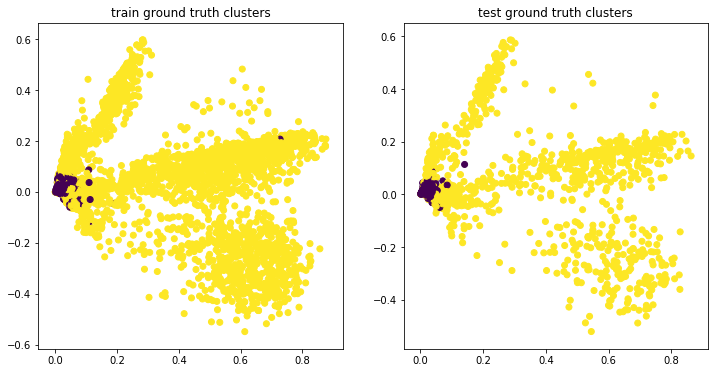

In [573]:
# VISUALIZING THE GROUND TRUTH IN TRAIN AND TEST DATA

y_train_gt = pd.Categorical(y_train).codes
y_test_gt = pd.Categorical(y_test).codes

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_gt)
plt.title('train ground truth clusters')

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=y_test_gt)
plt.title('test ground truth clusters')

plt.show()

In order to compare our unsupervised clustering algorithims to the ground truth, we will use __Adujusted Rand Index__ as a metric for evaluation. 

- __Adjusted Rand Index (ARI)__: Adjusted Rand Index. Rand index is defined as the number of pairs of objects that are either in the same group or in different groups in both partitions divided by the total number of pairs of objects. The Rand index lies between 0 and 1. When two partitions agree perfectly, the Rand index achieves the maximum value 1. The Adjusted Rand Index is adjusted for the chance grouping of elements.

### k-means & MiniBatchKMeans


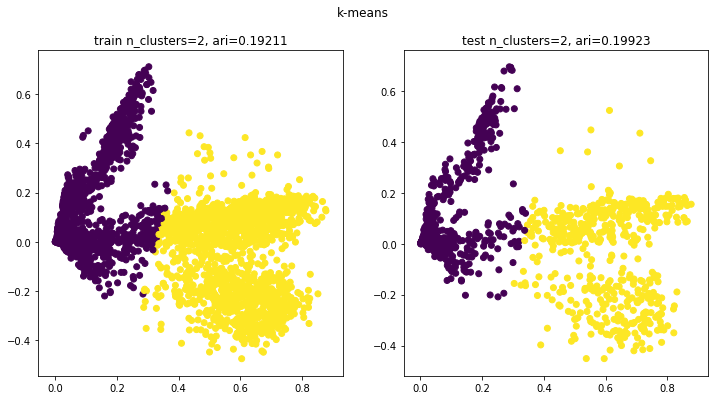

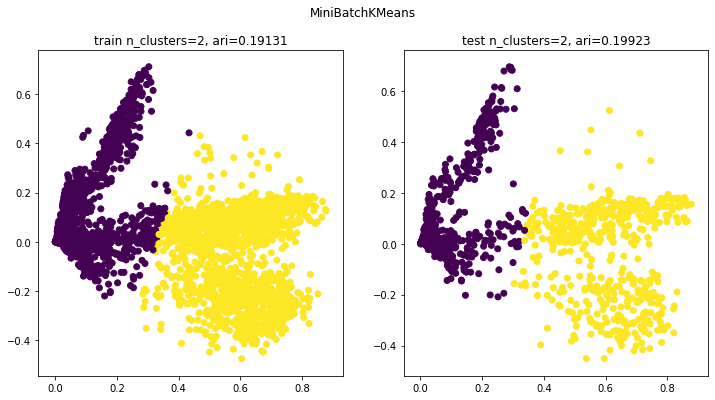

In [444]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix

# K-means
n_clust = 2
#k-means code
kmeans = KMeans(n_clusters=n_clust,
                init='k-means++',
                n_init=10)

y_pred_train = kmeans.fit_predict(X_train_svd)
y_pred_test = kmeans.predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('k-means')
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, y_pred_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=y_pred_test)
plt.title('test n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_test, y_pred_test)))

plt.show()

#minibatch code
mbkmeans = MiniBatchKMeans(init='random',
                           n_clusters=n_clust,
                           batch_size=100).fit(X_train_svd)

predict_mini_train = mbkmeans.predict(X_train_svd)
predict_mini_test = mbkmeans.predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('MiniBatchKMeans')
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=predict_mini_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, predict_mini_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_mini_test)
plt.title('test n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_test, predict_mini_test)))
plt.show()

__Result__: While K-means and MiniBatchKMeans both produce distinct clusters, they are relatively far off from the ground truth clusters. The ARI scores are not great either. 

## Spectral Clustering
- The main parameter in spectral clustering (aside from n_clusters) is the affinity parameter, which is user set similarity function for the algorithm to use.

- Spectral Clustering quantifies similarity between data points by defining a similarity matrix of n x n dimensions, where n = number of datapoints in the dataset

- The algorithim them defines a matrix of indices of similarity for each pairwise combination of datapoints, then applies a transformation matrix to calculate a set of eigenvectors with appropriate eigenvalues


- Kernels used in the project:
    - rbf (default)
    - sigmoid
    - nearest neighbors

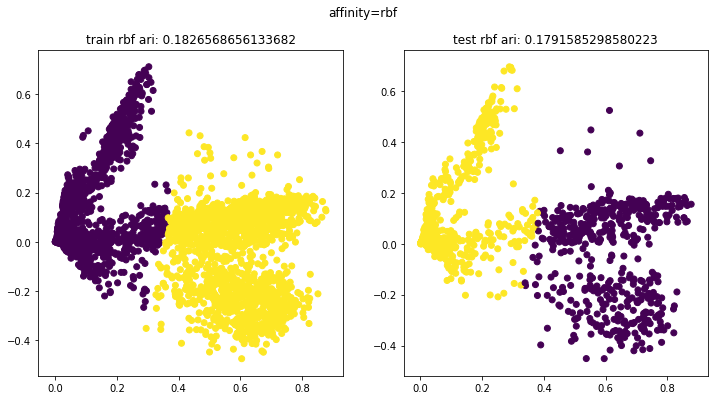

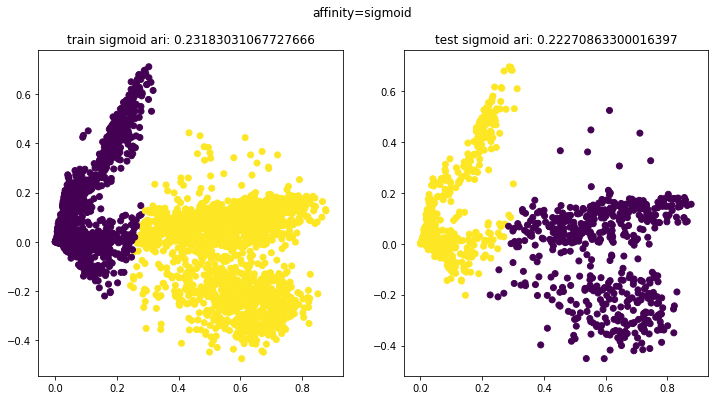

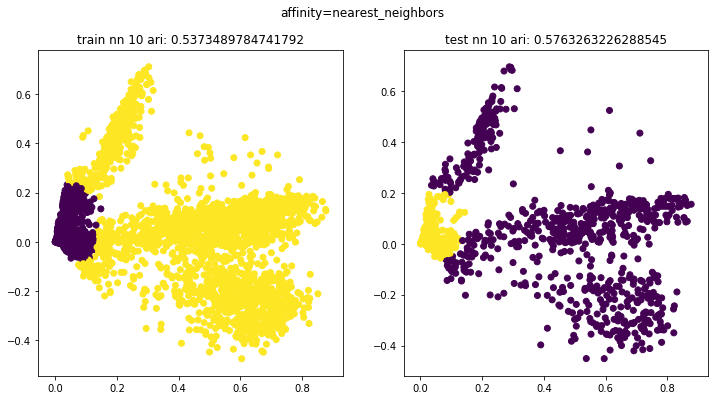

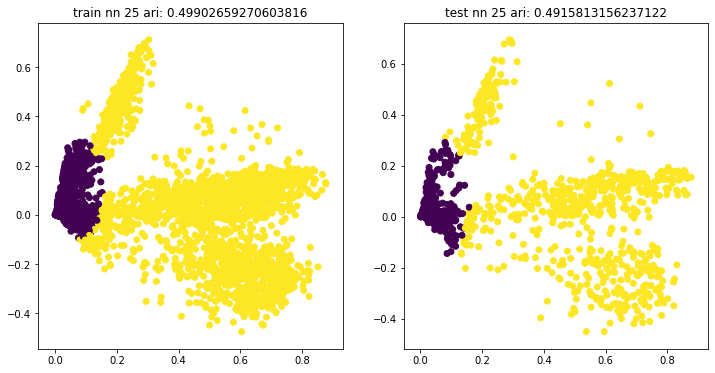

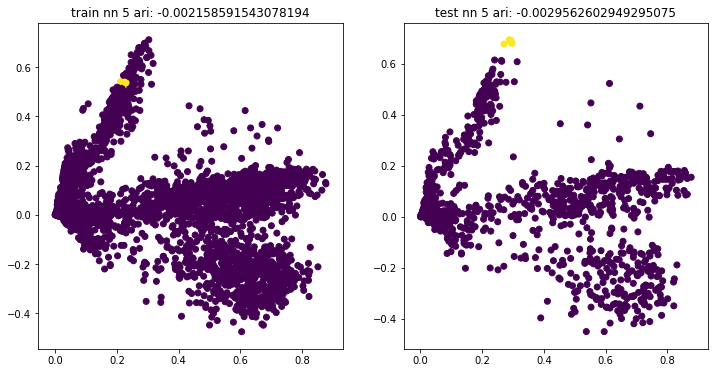

In [446]:
from sklearn.cluster import SpectralClustering

#rbf
sc_rbf = SpectralClustering(n_clusters=n_clust,
                            affinity='rbf').fit(X_train_svd)

predict_rbf_train = sc_rbf.fit_predict(X_train_svd)
predict_rbf_test = sc_rbf.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=rbf')
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_rbf_train)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train, predict_rbf_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_rbf_test)
plt.title('test rbf ari: {}'.format(
    adjusted_rand_score(y_test, predict_rbf_test)))
plt.show()

#sigmoid
sc_sig = SpectralClustering(n_clusters=n_clust,
                            affinity='sigmoid').fit(X_train_svd)

predict_sig_train = sc_sig.fit_predict(X_train_svd)
predict_sig_test = sc_sig.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=sigmoid')
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_sig_train)
plt.title('train sigmoid ari: {}'.format(adjusted_rand_score(
    y_train, predict_sig_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_sig_test)
plt.title('test sigmoid ari: {}'.format(
    adjusted_rand_score(y_test, predict_sig_test)))
plt.show()

#nearest neighbors = 10 (default)
sc_nn10 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd)

predict_nn10_train = sc_nn10.fit_predict(X_train_svd)
predict_nn10_test = sc_nn10.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=nearest_neighbors')
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn10_train)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn10_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_nn10_test)
plt.title('test nn 10 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn10_test)))
plt.show()

#nearest neighbors = 25
sc_nn25 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=25).fit(X_train_svd)

predict_nn25_train = sc_nn25.fit_predict(X_train_svd)
predict_nn25_test = sc_nn25.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn25_train)
plt.title('train nn 25 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn25_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_nn25_test)
plt.title('test nn 25 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn25_test)))
plt.show()

#nearest neighbors = 5
sc_nn5 = SpectralClustering(n_clusters=n_clust,
                            affinity='nearest_neighbors',
                            n_neighbors=5).fit(X_train_svd)

predict_nn5_train = sc_nn5.fit_predict(X_train_svd)
predict_nn5_test = sc_nn5.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn5_train)
plt.title('train nn 5 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn5_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_nn5_test)
plt.title('test nn 5 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn5_test)))
plt.show()

__Result:__ spectral clustering is very dependent on which similarity function it's using. Rbf (default) and sigmoid produce slightly better better ARI scores than k-means. Nearest neighbors shows a lot of promise in terms of agreement with ground truth clusters, but also exhibits large amounts of variance not only between different values of n_neighbors, but also between train & test sets for the same n_neighbors value.

Next up are clustering algorithms that do not take a user defined value for number of clusters - these decide how many clusters to generate based on their own interpretation of the data

### Mean Shift
- The mean shift algorithm is a nonparametric clustering technique which does not require prior knowledge of the number of clusters, and does not constrain the shape of the clusters.
- Mean Shift works by placing a kernel (weighting function) on each point on the dataset, and generates a probability surface. The peaks on the probablity surface dictate how many clusters are needed

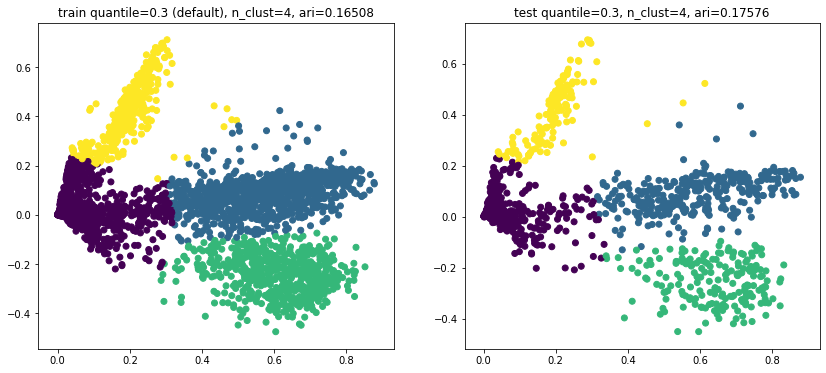

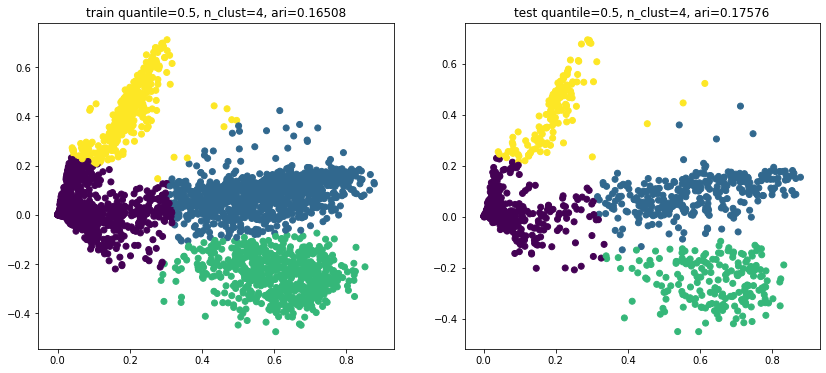

In [447]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train_svd, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms_train = ms.fit_predict(X_train_svd)
n_clusters_train = len(np.unique(ms_train))

ms_test = ms.fit_predict(X_test_svd)
n_clusters_test = len(np.unique(ms_test))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=ms_train)
plt.title('train quantile=0.3 (default), n_clust={}, ari={:0.5}'.format(
    n_clusters_train, adjusted_rand_score(y_train, ms_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=ms_test)
plt.title('test quantile=0.3, n_clust={}, ari={:0.5}'.format(
    n_clusters_test, adjusted_rand_score(y_test, ms_test)))

plt.show()

#try other values for quantile parameter in bandwidth
bandwidth2 = estimate_bandwidth(X_train_svd, quantile=0.5)
ms2 = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms_train2 = ms2.fit_predict(X_train_svd)
n_clusters_train2 = len(np.unique(ms_train2))

ms_test2 = ms2.fit_predict(X_test_svd)
n_clusters_test2 = len(np.unique(ms_test2))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=ms_train2)
plt.title('train quantile=0.5, n_clust={}, ari={:0.5}'.format(
    n_clusters_train2, adjusted_rand_score(y_train, ms_train2)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=ms_test)
plt.title('test quantile=0.5, n_clust={}, ari={:0.5}'.format(
    n_clusters_test2, adjusted_rand_score(y_test, ms_test2)))

plt.show()

__Result:__ Mean Shift seemed to consistently identify multiple clusters/classes, with lower ARI scores than Spectral Clustering. The Mean Shift Clusters are not a great method of identifying or seperating the classes. 

### Affinity Propagation

In Affinity Propagation the data points can be seen as a network where all the data points send messages to all other points. The subject of these messages are the willingness of the points being exemplars. Exemplars are points that explain the other data points ‘best’ and are the most significant of their cluster. A cluster only has one exemplar. All the data points want to collectively determine which data points are an exemplar for them.

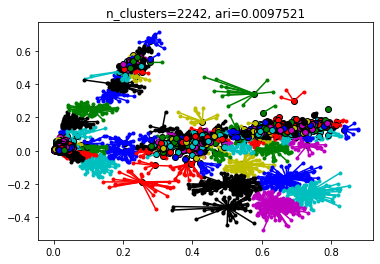

In [449]:
from sklearn.cluster import AffinityPropagation
from itertools import cycle

af = AffinityPropagation()
af_pred = af.fit_predict(X_train_svd)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train_svd[cluster_centers_indices[k]]
    plt.plot(
        X_train_svd[class_members, 0],
        X_train_svd[class_members, 1],
        col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train_svd[class_members]:
        plt.plot([cluster_center[0], x[0]],
                 [cluster_center[1], x[1]],
                 col)

plt.title('n_clusters={}, ari={:0.5}'.format(
    n_clusters_, adjusted_rand_score(y_train, af_pred)))
plt.show()

__Result:__ The Affinity Propagation algorithm yields pretty unreasonable results, finding 2242 clusters compared to a 2-class ground truth. Affinity Propagation is also computationally very intensive, taking the longest to run.

## Supervised Learning Classification of 1st set (earn & acq classes)

- Assessing models on their accuracy, but evaluating them on their __f1 score__ (the mean of the precision and recall of the predictions)

In [575]:
# Importing models: 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier


# Model evaluation metrics: 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score



def classifier(model):
    if model == 'knn':
        model_name = "K-Nearest Neighbors Classifier"
        model = KNeighborsClassifier()
    elif model == 'lr':
        model_name = "Logistic Regression Classifier"
        model = LogisticRegression()
    elif model == 'rfc':
        model_name = "Random Forest Classifier"
        model = RandomForestClassifier()
    elif model == 'svc':
        model_name = "Support Vectors Classifier"
        model = SVC()
    elif model == 'xgb':
        model_name = "Xtreme Gradient Boost Classifier"
        model = xgb.XGBClassifier()
    
    model.fit(X_train_tfidf, y_train)
    
    print('{} Accuracy:'.format(model_name))
    print('train 10 cv mean: {}'.format(cross_val_score(model, X_train_tfidf, y_train, cv=10).mean()))
    print('test 10 cv mean: {}'.format(cross_val_score(model, X_test_tfidf, y_test, cv=10).mean()))
    print("Predictions")
    y_pred = model.predict(X_test_tfidf)
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print("f1 score: ", f1_score(y_test, y_pred, average='macro'))
    print("\n")



    model.fit(X_train_svd, y_train)

    print('{} with LSA accuracy: '.format(model_name))
    print('train 10 cv mean: {}'.format(cross_val_score(model, X_train_svd, y_train, cv=10).mean()))
    print('test 10 cv mean: {}'.format(cross_val_score(model, X_test_svd, y_test, cv=10).mean()))
    print("Predictions")
    y_pred = model.predict(X_test_svd)
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print("f1 score: ", f1_score(y_test, y_pred, average='macro'))

    return

    


In [577]:
classifier('knn')

K-Nearest Neighbors Classifier Accuracy:
train 10 cv mean: 0.901755104021247
test 10 cv mean: 0.9395114025759188
Predictions
Confusion Matrix
[[426 149]
 [ 21 958]]
f1 score:  0.8760819028356033


K-Nearest Neighbors Classifier with LSA accuracy: 
train 10 cv mean: 0.9377813883261921
test 10 cv mean: 0.9433494999624032
Predictions
Confusion Matrix
[[536  39]
 [ 61 918]]
f1 score:  0.9315114376780527


In [565]:
classifier('lr')

Logistic Regression Classifier Accuracy:
train 10 cv mean: 0.9809072335448376
test 10 cv mean: 0.9658804636223991
Predictions
Confusion Matrix
[[576  13]
 [ 30 935]]
f1 score:  0.9707694764078416


Logistic Regression Classifier with LSA accuracy: 
train 10 cv mean: 0.9302711636819609
test 10 cv mean: 0.9131052281052281
Predictions
Confusion Matrix
[[566  23]
 [ 83 882]]
f1 score:  0.9288467685502751


In [566]:
classifier('rfc')

Random Forest Classifier Accuracy:
train 10 cv mean: 0.9661021651135643
test 10 cv mean: 0.9555785075139914
Predictions
Confusion Matrix
[[582   7]
 [ 39 926]]
f1 score:  0.9688737165698561


Random Forest Classifier with LSA accuracy: 
train 10 cv mean: 0.9384215443904262
test 10 cv mean: 0.9337049509630155
Predictions
Confusion Matrix
[[545  44]
 [ 54 911]]
f1 score:  0.9332333754208754


In [488]:
classifier('svc')

Support Vectors Classifier Accuracy:
train 10 cv mean: 0.6346281798873316
test 10 cv mean: 0.6209770337189692
Predictions
Confusion Matrix
[[  0 589]
 [  0 965]]
f1 score:  0.3830885271933307


Support Vectors Classifier with LSA accuracy: 
train 10 cv mean: 0.9017372423309116
test 10 cv mean: 0.8699906545067835
Predictions
Confusion Matrix
[[583   6]
 [156 809]]
f1 score:  0.8935004061188574


In [567]:
classifier('xgb')

Xtreme Gradient Boost Classifier Accuracy:
train 10 cv mean: 0.97361338586202
test 10 cv mean: 0.972981588304169
Predictions
Confusion Matrix
[[579  10]
 [ 21 944]]
f1 score:  0.9788867116537691


Xtreme Gradient Boost Classifier with LSA accuracy: 
train 10 cv mean: 0.9478663911964151
test 10 cv mean: 0.9362814604750088
Predictions
Confusion Matrix
[[545  44]
 [ 41 924]]
f1 score:  0.9418432378289727


__Bonus__: Trying out a Neural Network - Multi Layer Perceptron. 

In [502]:
# Preprocessing for certain models: 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

model_name = "Multi-layer Perceptron Classifier"
model = MLPClassifier()
scaler.fit(X_train_tfidf)
X_train_tfidf = scaler.transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)
scaler.fit(X_train_svd)
X_train_svd = scaler.fit_transform(X_train_svd)
X_test_svd = scaler.transform(X_test_svd)

model.fit(X_train_tfidf, y_train)
    
print('{} Accuracy:'.format(model_name))
print('train 10 cv mean: {}'.format(cross_val_score(model, X_train_tfidf, y_train, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(model, X_test_tfidf, y_test, cv=10).mean()))
print("Predictions")
y_pred = model.predict(X_test_tfidf)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("f1 score: ", f1_score(y_test, y_pred, average='macro'))
print("\n")



model.fit(X_train_svd, y_train)

print('{} with LSA accuracy: '.format(model_name))
print('train 10 cv mean: {}'.format(cross_val_score(model, X_train_svd, y_train, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(model, X_test_svd, y_test, cv=10).mean()))
print("Predictions")
y_pred = model.predict(X_test_svd)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("f1 score: ", f1_score(y_test, y_pred, average='macro'))

Multi-layer Perceptron Classifier Accuracy:
train 10 cv mean: 0.9615943389262412
test 10 cv mean: 0.9517490036844876
Predictions
Confusion Matrix
[[546  43]
 [ 35 930]]
f1 score:  0.9465428276573787


Multi-layer Perceptron Classifier with LSA accuracy: 
train 10 cv mean: 0.9392817594441898
test 10 cv mean: 0.9401401823982468
Predictions
Confusion Matrix
[[559  30]
 [ 54 911]]
f1 score:  0.943022559462805


__Result:__ even without tuning any parameters, these classifiers all perform quite well and produce favorable results compared to the clustering algorithms. The models were trained and tested with and without LSA-dimensionality-reduced features. The K-Nearest Neighbors , Support Vectors and Multi Layer Perceptron classififers performed as good or better with LSA, while the other classifier models did not. XGBoost and logistic regression are particularly effective at classifying this data.

## Repeating the process with 2nd set
- now clustering with 8 classes (top 2-10)


In [585]:
print('top categories (2-10):\n{}'.format(df['category'].value_counts().head(10)[2:10]))

top categories (2-10):
crude           374
trade           326
money-fx        309
interest        272
money-supply    151
ship            144
sugar           122
coffee          112
Name: category, dtype: int64


In [586]:
# Create 2nd set of data:
set2 = df[df['category'].isin(['crude', 'trade', 'money-fx', 'interest', 'money-supply', 'ship', 'sugar', 'coffee'])]


# Create train and test sets
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    set2['text'], set2['category'], test_size=0.25)

# verify class ratio between train & test sets

for index, category in enumerate(set2.category.value_counts().reset_index()['index']):
    print('"{}" train class balance: {:0.04}'.format(category, y_train_.value_counts(normalize=True)[index]))
print("\n")
for index, category in enumerate(set2.category.value_counts().reset_index()['index']):     
    print('"{}" test class balance: {:0.04}'.format(category, y_test_.value_counts(normalize=True)[index]))


"crude" train class balance: 0.2027
"trade" train class balance: 0.182
"money-fx" train class balance: 0.1754
"interest" train class balance: 0.1511
"money-supply" train class balance: 0.07885
"ship" train class balance: 0.07738
"sugar" train class balance: 0.06853
"coffee" train class balance: 0.06411


"crude" test class balance: 0.2185
"trade" test class balance: 0.1744
"money-fx" test class balance: 0.1567
"interest" test class balance: 0.1479
"money-supply" test class balance: 0.1015
"ship" test class balance: 0.08168
"sugar" test class balance: 0.06402
"coffee" test class balance: 0.05519


In [587]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english',
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

In [588]:
#train vectors
X_train_tfidf_ = vectorizer.fit_transform(X_train_)
print('train features: {}'.format(X_train_tfidf_.get_shape()[1]))

#test vectors
X_test_tfidf_ = vectorizer.transform(X_test_)
print('test features: {}'.format(X_test_tfidf_.get_shape()[1]))

train features: 5988
test features: 5988


In [589]:
X_train_norm_ = normalize(X_train_tfidf_)
X_test_norm_ = normalize(X_test_tfidf_)

svd = TruncatedSVD(8)
X_train_svd_ = svd.fit_transform(X_train_norm_)
X_test_svd_ = svd.transform(X_test_norm_)

n_clust_ = 8

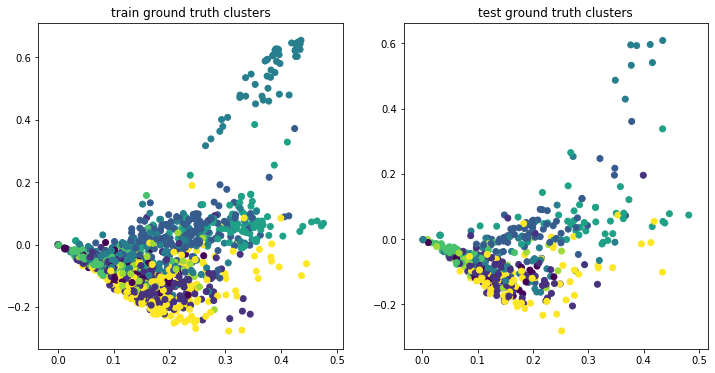

In [590]:
y_train_gt_ = pd.Categorical(y_train_).codes
y_test_gt_ = pd.Categorical(y_test_).codes

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:, 0], X_train_svd_[:, 1], c=y_train_gt_)
plt.title('train ground truth clusters')

plt.subplot(122)
plt.scatter(X_test_svd_[:, 0], X_test_svd_[:, 1], c=y_test_gt_)
plt.title('test ground truth clusters')
plt.show()

While these plots are an oversimplified representation of the ground truth clusters, these classes appear to less clearly defined in comparison to the earn/acq dataset.

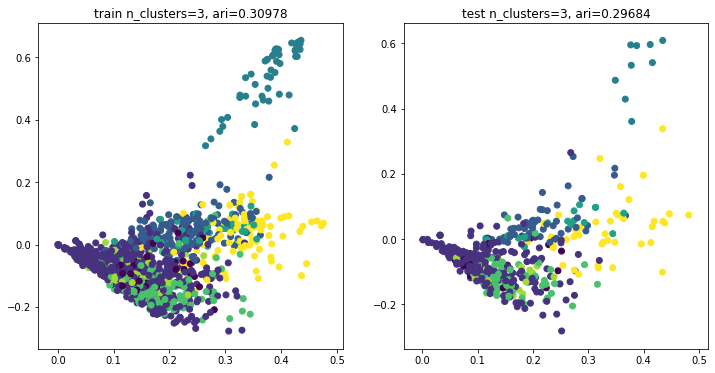

In [591]:
n_clust_ = 8
kmeans_ = KMeans(n_clusters=n_clust_,
                 init='k-means++',
                 n_init=10).fit(X_train_svd_)

y_pred_train_ = kmeans_.predict(X_train_svd_)
y_pred_test_ = kmeans_.predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:, 0], X_train_svd_[:, 1], c=y_pred_train_)
plt.title('train n_clusters=3, ari={:0.5}'.format(
    adjusted_rand_score(y_train_, y_pred_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=y_pred_test_)
plt.title('test n_clusters=3, ari={:0.5}'.format(
    adjusted_rand_score(y_test_, y_pred_test_)))
plt.show()

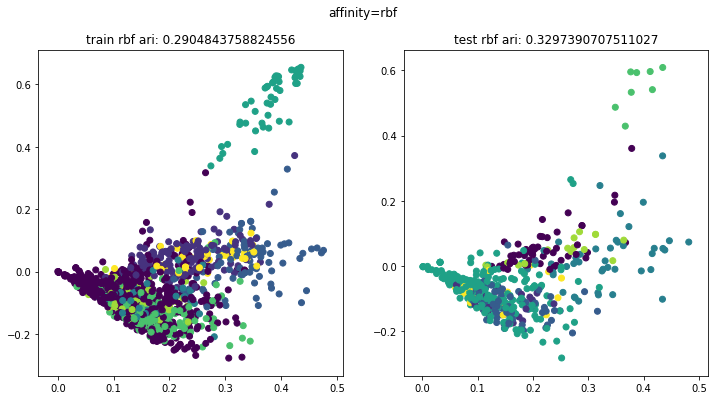

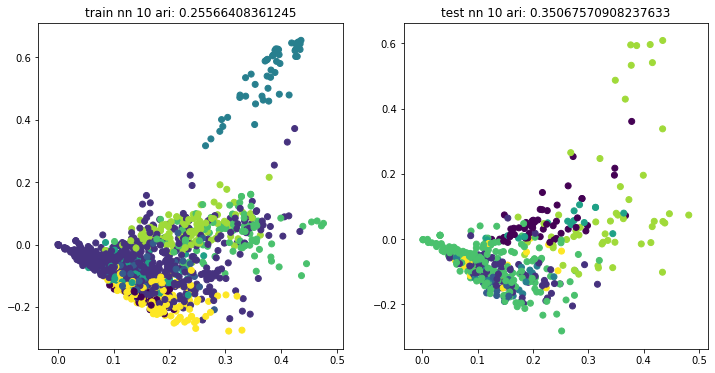

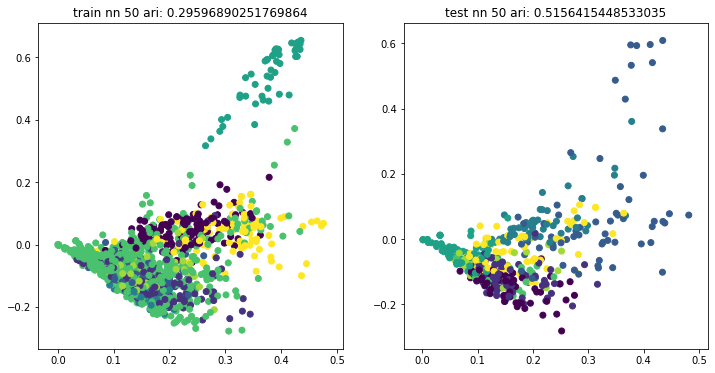

In [592]:
#rbf
sc_rbf_ = SpectralClustering(n_clusters=n_clust_,
                            affinity='rbf').fit(X_train_svd_)

predict_rbf_train_ = sc_rbf_.fit_predict(X_train_svd_)
predict_rbf_test_ = sc_rbf_.fit_predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=rbf')
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_rbf_train_)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train_, predict_rbf_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=predict_rbf_test_)
plt.title('test rbf ari: {}'.format(
    adjusted_rand_score(y_test_, predict_rbf_test_)))
plt.show()

#nearest neighbors = 10
sc_nn10_ = SpectralClustering(n_clusters=n_clust_,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd_)

predict_nn10_train_ = sc_nn10_.fit_predict(X_train_svd_)
predict_nn10_test_ = sc_nn10_.fit_predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn10_train_)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn10_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=predict_nn10_test_)
plt.title('test nn 10 ari: {}'.format(
    adjusted_rand_score(y_test_, predict_nn10_test_)))
plt.show()

#nearest neighbors = 50
sc_nn50_ = SpectralClustering(n_clusters=n_clust_,
                            affinity='nearest_neighbors',
                            n_neighbors=50).fit(X_train_svd_)

predict_nn50_train_ = sc_nn50_.fit_predict(X_train_svd_)
predict_nn50_test_ = sc_nn50_.fit_predict(X_test_svd_)

#plotsm
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn50_train_)
plt.title('train nn 50 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn50_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=predict_nn50_test_)
plt.title('test nn 50 ari: {}'.format(
    adjusted_rand_score(y_test_, predict_nn50_test_)))
plt.show()

__Results:__ perhaps due to the peculiarities of the 3 class data and their overlapping characteristics, these algorithms are much less capable this time around. Especially concerning is the vast difference in ARI scores between train and test sets, where the test set is actually much higher than the train set. Some randomness of the train_test_split for this iteration may have an effect here, even though the results of that do result in equivalent class ratios (as shown in the first section)

## Supervised Classification on 2nd set:

In [602]:
def classifier2(model):
    if model == 'knn':
        model_name = "K-Nearest Neighbors Classifier"
        model = KNeighborsClassifier()
    elif model == 'lr':
        model_name = "Logistic Regression Classifier"
        model = LogisticRegression()
    elif model == 'rfc':
        model_name = "Random Forest Classifier"
        model = RandomForestClassifier()
    elif model == 'svc':
        model_name = "Support Vectors Classifier"
        model = SVC()
    elif model == 'xgb':
        model_name = "Xtreme Gradient Boost Classifier"
        model = xgb.XGBClassifier()
    
   
    model.fit(X_train_tfidf_, y_train_)
    
    print('{} Accuracy:'.format(model_name))
    print('train 10 cv mean: {}'.format(cross_val_score(model, X_train_tfidf_, y_train_, cv=10).mean()))
    print('test 10 cv mean: {}'.format(cross_val_score(model, X_test_tfidf_, y_test_, cv=10).mean()))
    print("Predictions")
    y_pred_ = model.predict(X_test_tfidf_)
    print("Confusion Matrix")
    print(confusion_matrix(y_test_, y_pred_))
    print("f1 score: ", f1_score(y_test_, y_pred_, average='macro'))
    print("\n")



    model.fit(X_train_svd_, y_train_)

    print('{} with LSA accuracy: '.format(model_name))
    print('train 10 cv mean: {}'.format(cross_val_score(model, X_train_svd_, y_train_, cv=10).mean()))
    print('test 10 cv mean: {}'.format(cross_val_score(model, X_test_svd_, y_test_, cv=10).mean()))
    print("Predictions")
    y_pred_ = model.predict(X_test_svd_)
    print("Confusion Matrix")
    print(confusion_matrix(y_test_, y_pred_))
    print("f1 score: ", f1_score(y_test_, y_pred_, average='macro'))
    return

    


In [603]:
classifier2('knn')

K-Nearest Neighbors Classifier Accuracy:
train 10 cv mean: 0.874942791766245
test 10 cv mean: 0.8511486128740018
Predictions
Confusion Matrix
[[25  0  0  0  0  0  0  0]
 [ 0 95  0  1  0  1  1  1]
 [ 1  1 54  9  1  0  0  1]
 [ 0  1  7 56  2  0  3  2]
 [ 0  0  3  1 42  0  0  0]
 [ 1  6  0  0  0 29  0  1]
 [ 1  0  0  0  0  1 27  0]
 [ 0  5  1  2  1  0  0 70]]
f1 score:  0.8818160005693181


K-Nearest Neighbors Classifier with LSA accuracy: 
train 10 cv mean: 0.8558831839877644
test 10 cv mean: 0.856377122341023
Predictions
Confusion Matrix
[[25  0  0  0  0  0  0  0]
 [ 0 96  0  0  0  3  0  0]
 [ 0  0 48 17  1  1  0  0]
 [ 0  3  7 53  1  4  0  3]
 [ 0  0  5  3 37  0  0  1]
 [ 0  1  0  1  0 34  1  0]
 [ 1  1  0  0  0  0 27  0]
 [ 0  0  1  1  1  1  1 74]]
f1 score:  0.8750742890495473


In [595]:
classifier2('lr')

Logistic Regression Classifier Accuracy:
train 10 cv mean: 0.9352376771605677
test 10 cv mean: 0.8757188231300811
Predictions
Confusion Matrix
[[25  0  0  0  0  0  0  0]
 [ 0 99  0  0  0  0  0  0]
 [ 0  0 59  7  0  0  0  1]
 [ 0  1 11 55  1  0  0  3]
 [ 0  0  3  2 40  0  0  1]
 [ 0  3  0  1  0 33  0  0]
 [ 1  1  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0 79]]
f1 score:  0.9254313159577349


Logistic Regression Classifier with LSA accuracy: 
train 10 cv mean: 0.7948126975694685
test 10 cv mean: 0.7375442873977821
Predictions
Confusion Matrix
[[24  0  0  0  0  1  0  0]
 [ 0 98  0  0  0  0  0  1]
 [ 0  0 55  8  0  0  0  4]
 [ 0  1  8 40  1  3  0 18]
 [ 0  0  9 14 22  0  0  1]
 [ 0 25  0  4  0  5  0  3]
 [ 0  1  0  0  0  5 23  0]
 [ 0  0  0  1  2  0  0 76]]
f1 score:  0.7201557311436217


In [596]:
classifier2('rfc')

Random Forest Classifier Accuracy:
train 10 cv mean: 0.8821571624013081
test 10 cv mean: 0.8291622415124286
Predictions
Confusion Matrix
[[24  0  0  0  0  0  0  1]
 [ 0 99  0  0  0  0  0  0]
 [ 0  1 57  7  1  0  0  1]
 [ 0  3 11 52  0  0  0  5]
 [ 0  1  3  4 36  0  0  2]
 [ 1  5  0  0  0 30  1  0]
 [ 0  3  0  0  0  3 23  0]
 [ 1  2  1  3  1  0  0 71]]
f1 score:  0.865664238931773


Random Forest Classifier with LSA accuracy: 
train 10 cv mean: 0.8328914522788432
test 10 cv mean: 0.8546694878892401
Predictions
Confusion Matrix
[[24  0  0  0  0  1  0  0]
 [ 0 96  0  1  1  1  0  0]
 [ 0  0 52 14  0  0  0  1]
 [ 0  1  9 50  3  4  0  4]
 [ 0  0  6  2 37  0  0  1]
 [ 0  2  0  1  0 33  1  0]
 [ 0  0  0  0  0  3 26  0]
 [ 0  0  0  1  1  1  1 75]]
f1 score:  0.8694229645457412


In [597]:
classifier2('svc')

Support Vectors Classifier Accuracy:
train 10 cv mean: 0.2026872843215335
test 10 cv mean: 0.2189126968760383
Predictions
Confusion Matrix
[[ 0 25  0  0  0  0  0  0]
 [ 0 99  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0]
 [ 0 71  0  0  0  0  0  0]
 [ 0 46  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0]
 [ 0 79  0  0  0  0  0  0]]
f1 score:  0.04483695652173913


Support Vectors Classifier with LSA accuracy: 
train 10 cv mean: 0.7665876725245839
test 10 cv mean: 0.5405800955905026
Predictions
Confusion Matrix
[[21  2  0  2  0  0  0  0]
 [ 0 96  0  3  0  0  0  0]
 [ 0  0 44 22  0  0  0  1]
 [ 0  0  3 62  1  0  0  5]
 [ 0  0  7 14 24  0  0  1]
 [ 0  1  0 34  0  0  0  2]
 [ 0  1  0  8  0  0 20  0]
 [ 0  0  0  3  5  0  0 71]]
f1 score:  0.6890422013482085


In [598]:
classifier2('xgb')

Xtreme Gradient Boost Classifier Accuracy:
train 10 cv mean: 0.9131971328869781
test 10 cv mean: 0.8830476344995901
Predictions
Confusion Matrix
[[24  0  0  1  0  0  0  0]
 [ 0 97  0  0  0  2  0  0]
 [ 0  0 57  8  0  0  0  2]
 [ 0  1  4 59  1  0  0  6]
 [ 0  0  4  4 38  0  0  0]
 [ 1  1  0  1  0 34  0  0]
 [ 0  0  0  1  0  4 24  0]
 [ 0  0  0  4  0  0  0 75]]
f1 score:  0.9005251857024124


Xtreme Gradient Boost Classifier with LSA accuracy: 
train 10 cv mean: 0.8595138141666615
test 10 cv mean: 0.8788620720358935
Predictions
Confusion Matrix
[[25  0  0  0  0  0  0  0]
 [ 0 95  0  0  1  3  0  0]
 [ 0  0 52 13  0  1  0  1]
 [ 0  2  9 51  3  3  0  3]
 [ 0  0  4  4 37  0  0  1]
 [ 0  2  1  0  0 33  0  1]
 [ 0  0  0  0  0  3 26  0]
 [ 0  0  0  0  0  2  2 75]]
f1 score:  0.8725746574541056


__Result:__ Again, these classification algorithms are much superior to clustering when it comes to classifying this data. They do tend to exhibit some overfitting which could be mitigated with some parameter tuning, but even in vanilla form they are much more consistent between train/test sets, which seemed to throw off the clustering algorithms.